Der Programmcode zu diesem Notebook kommt aus https://medium.com/geekculture/step-by-step-decision-tree-id3-algorithm-from-scratch-in-python-no-fancy-library-4822bbfdd88f


In [ ]:
#Tennis?
data = {
  "Day": ["D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8", "D9", "D10", "D11", "D12", "D13", "D14"],
  "Outlook": ["Sunny", "Sunny", "Overcast", "Rain", "Rain", "Rain", "Overcast", "Sunny", "Sunny", "Rain", "Sunny", "Overcast", "Overcast", "Rain"],
  "Temp": ["Hot", "Hot", "Hot", "Mild", "Cool", "Cool", "Cool", "Mild", "Cool", "Mild", "Mild", "Mild", "Hot", "Mild"],
  "Humidity" : [ "High", "High", "High", "High", "Normal", "Normal", "Normal", "High", "Normal", "Normal", "Normal", "High", "Normal", "High"],
  "Wind" : [ "Weak", "Strong", "Weak", "Weak","Weak", "Strong", "Strong", "Weak", "Weak", "Weak", "Strong", "Strong", "Weak", "Strong"],
  "PlayTennis" : ["No", "No", "Yes", "Yes", "Yes", "No", "Yes", "No", "Yes", "Yes", "Yes", "Yes", "Yes", "No"]
}

In [103]:
#Surfen?
data = {
    "Weather": ["Sunny", "Rain", "Sunny", "Cloudy", "Sunny", "Cloudy", "Rain", "Cloudy", "Cloudy"],
    "WaterTemp": ["Low", "Medium", "High", "Low", "Medium", "High", "Medium", "High", "Low"],
    "WaveHeight": [">=8ft", "<8ft", ">=8ft", "<8ft", ">=8ft", "<8ft", ">=8ft", ">=8ft", ">=8ft"],
    "GoSurfing": ["Yes", "No", "Yes", "No", "Yes", "No", "No", "Yes", "No"]
}

In [ ]:
#enthält einen widerspruch!
data = {
    "Weather": ["Sunny", "Rain", "Sunny", "Cloudy", "Sunny", "Cloudy", "Rain", "Cloudy", "Cloudy", "Cloudy"],
    "WaterTemp": ["Low", "Medium", "High", "Low", "Medium", "High", "Medium", "High", "Low", "Low"],
    "WaveHeight": [">=8ft", "<8ft", ">=8ft", "<8ft", ">=8ft", "<8ft", ">=8ft", ">=8ft", ">=8ft", ">=8ft"],
    "GoSurfing": ["Yes", "No", "Yes", "No", "Yes", "No", "No", "Yes", "No", "Yes"]

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

def calc_total_entropy(train_data, label, class_list):
    total_row = train_data.shape[0] #the total size of the dataset
    total_entr = 0

    for c in class_list: #for each class in the label
        total_class_count = train_data[train_data[label] == c].shape[0] #number of the class
        total_class_entr = - (total_class_count/total_row)*np.log2(total_class_count/total_row) #entropy of the class
        total_entr += total_class_entr #adding the class entropy to the total entropy of the dataset

    return total_entr

def calc_entropy(feature_value_data, label, class_list):
    class_count = feature_value_data.shape[0]
    entropy = 0

    for c in class_list:
        label_class_count = feature_value_data[feature_value_data[label] == c].shape[0] #row count of class c
        entropy_class = 0
        if label_class_count != 0:
            probability_class = label_class_count/class_count #probability of the class
            entropy_class = - probability_class * np.log2(probability_class)  #entropy
        entropy += entropy_class
    return entropy

def calc_info_gain(feature_name, train_data, label, class_list):
    feature_value_list = train_data[feature_name].unique() #unqiue values of the feature
    total_row = train_data.shape[0]
    feature_info = 0.0

    for feature_value in feature_value_list:
        feature_value_data = train_data[train_data[feature_name] == feature_value] #filtering rows with that feature_value
        feature_value_count = feature_value_data.shape[0]
        feature_value_entropy = calc_entropy(feature_value_data, label, class_list) #calculcating entropy for the feature value
        feature_value_probability = feature_value_count/total_row
        feature_info += feature_value_probability * feature_value_entropy #calculating information of the feature value

    return calc_total_entropy(train_data, label, class_list) - feature_info #calculating information gain by subtracting

def find_most_informative_feature(train_data, label, class_list):
    feature_list = train_data.columns.drop(label) #finding the feature names in the dataset
                                            #N.B. label is not a feature, so dropping it
    max_info_gain = -1
    max_info_feature = None

    for feature in feature_list:  #for each feature in the dataset
        feature_info_gain = calc_info_gain(feature, train_data, label, class_list)
        if max_info_gain < feature_info_gain: #selecting feature name with highest information gain
            max_info_gain = feature_info_gain
            max_info_feature = feature

    return max_info_feature

def generate_sub_tree(feature_name, train_data, label, class_list):
    feature_value_count_dict = train_data[feature_name].value_counts(sort=False) #dictionary of the count of unqiue feature value
    tree = {} #sub tree or node

    for feature_value, count in feature_value_count_dict.items():
        feature_value_data = train_data[train_data[feature_name] == feature_value] #dataset with only feature_name = feature_value

        assigned_to_node = False #flag for tracking feature_value is pure class or not
        for c in class_list: #for each class
            class_count = feature_value_data[feature_value_data[label] == c].shape[0] #count of class c

            if class_count == count: #count of (feature_value = count) of class (pure class)
                tree[feature_value] = c #adding node to the tree
                train_data = train_data[train_data[feature_name] != feature_value] #removing rows with feature_value
                assigned_to_node = True
        if not assigned_to_node: #not pure class
            tree[feature_value] = "?" #as feature_value is not a pure class, it should be expanded further,
                                      #so the branch is marking with ?

    return tree, train_data

def make_tree(root, prev_feature_value, train_data, label, class_list):
    if train_data.shape[0] != 0: #if dataset becomes enpty after updating
        max_info_feature = find_most_informative_feature(train_data, label, class_list) #most informative feature
        tree, train_data = generate_sub_tree(max_info_feature, train_data, label, class_list) #getting tree node and updated dataset
        next_root = None

        if prev_feature_value != None: #add to intermediate node of the tree
            root[prev_feature_value] = dict()
            root[prev_feature_value][max_info_feature] = tree
            next_root = root[prev_feature_value][max_info_feature]
        else: #add to root of the tree
            root[max_info_feature] = tree
            next_root = root[max_info_feature]

        for node, branch in list(next_root.items()): #iterating the tree node
            if branch == "?": #if it is expandable
                feature_value_data = train_data[train_data[max_info_feature] == node] #using the updated dataset
                make_tree(next_root, node, feature_value_data, label, class_list) #recursive call with updated dataset

def plot_decision_tree(decision_tree):
    dot = Digraph()

    def add_nodes_edges(dot, decision_tree, parent=None):
        if not isinstance(decision_tree, dict) or len(decision_tree) != 1:
            raise ValueError("Invalid decision tree node: " + repr(decision_tree))

        root = list(decision_tree.keys())[0]
        children = list(decision_tree[root].keys())

        if parent is not None:
            dot.edge(parent, root)

        for child in children:
            if isinstance(decision_tree[root][child], dict):
                add_nodes_edges(dot, {child: decision_tree[root][child]}, root)
            else:
                dot.edge(root, child, label=str(decision_tree[root][child]))

    add_nodes_edges(dot, decision_tree)
    dot.render('decision_tree', format='png', cleanup=True)
    return plt.imread('decision_tree.png')



#load data into a DataFrame object:
df = pd.DataFrame(data)

print(df)

  Weather WaterTemp WaveHeight GoSurfing
0   Sunny       Low      >=8ft       Yes
1    Rain    Medium       <8ft        No
2   Sunny      High      >=8ft       Yes
3  Cloudy       Low       <8ft        No
4   Sunny    Medium      >=8ft       Yes
5  Cloudy      High       <8ft        No
6    Rain    Medium      >=8ft        No
7  Cloudy      High      >=8ft       Yes
8  Cloudy       Low      >=8ft        No


In [107]:
calc_total_entropy(df, "GoSurfing", ["Yes", "No"])

0.9910760598382222

In [108]:
sunnydf = df.set_index("Weather").loc[["Sunny"]]
calc_entropy(sunnydf, "GoSurfing", ["Yes", "No"])

0.0

In [109]:
calc_info_gain("Weather", df, "GoSurfing", ["Yes", "No"])

0.6305080045230521

In [110]:
find_most_informative_feature(df, "GoSurfing", ["Yes", "No"])

'Weather'

In [111]:
generate_sub_tree("WaterTemp", df, "GoSurfing", ["Yes", "No"])

({'Low': '?', 'Medium': '?', 'High': '?'},
   Weather WaterTemp WaveHeight GoSurfing
 0   Sunny       Low      >=8ft       Yes
 1    Rain    Medium       <8ft        No
 2   Sunny      High      >=8ft       Yes
 3  Cloudy       Low       <8ft        No
 4   Sunny    Medium      >=8ft       Yes
 5  Cloudy      High       <8ft        No
 6    Rain    Medium      >=8ft        No
 7  Cloudy      High      >=8ft       Yes
 8  Cloudy       Low      >=8ft        No)

In [112]:
decissiontree = dict()
make_tree(decissiontree, None, df, "GoSurfing", ["Yes", "No"])
print(decissiontree)

{'Weather': {'Sunny': 'Yes', 'Rain': 'No', 'Cloudy': {'WaterTemp': {'Low': 'No', 'High': {'WaveHeight': {'<8ft': 'No', '>=8ft': 'Yes'}}}}}}


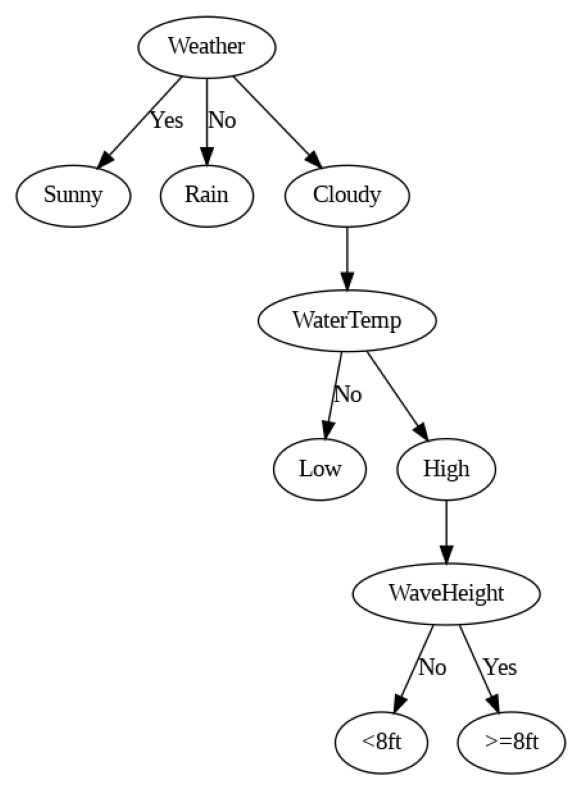

In [113]:
plt.figure(figsize=(10, 10))
plt.imshow(plot_decision_tree(decissiontree))
plt.axis('off')
plt.show()